# **Fine-tuning with Food101 dataset**

This project explores transfer learning techniques, specifically feature extraction and **fine-tuning**, using the `efficientnet model`. The experiments focus on a subset of the food101 images dataset, utilizing only 10% of the data.

The project aims to leverage the pre-trained efficientnet model to extract meaningful features from the images and then fine-tune the model to improve its performance on custom food classification tasks.

In [ ]:
import tensorflow as tf

In [ ]:
# get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-01-10 00:18:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c07::80, 2a00:1450:4013:c16::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  37.5MB/s    in 4.9s    

2023-01-10 00:18:19 (32.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# get helper functions
!wget https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_eval.py

--2023-01-10 00:18:19--  https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1188 (1.2K) [text/plain]
Saving to: ‘useful_functions_eval.py’

useful_functions_ev 100%[===================>]   1.16K  --.-KB/s    in 0s      

2023-01-10 00:18:20 (50.6 MB/s) - ‘useful_functions_eval.py’ saved [1188/1188]



In [ ]:
!wget https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_img.py

--2023-01-10 00:18:20--  https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4680 (4.6K) [text/plain]
Saving to: ‘useful_functions_img.py’

useful_functions_im 100%[===================>]   4.57K  --.-KB/s    in 0s      

2023-01-10 00:18:20 (57.0 MB/s) - ‘useful_functions_img.py’ saved [4680/4680]



## Preprocessing the data

In [ ]:
# unzip the data
import zipfile

data_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
data_ref.extractall()
data_ref.close()

In [ ]:
# set directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# set data loaders
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode="categorical", image_size=(224,224))
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=(224,224))

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# check class names
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Data augmentation

In [ ]:
from tensorflow.keras import layers

# create an augmentation layer as a Sequential
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomHeight(0.2),
    layers.experimental.preprocessing.RandomWidth(0.2)
    #layers.experimental.preprocessing.Rescaling(1./255) -> efficientnet already has rescaling built-in!!!
])

## TensorBoard callback

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  """
    creates a tensorboard callback and stores it in log files

  """
  # set callback's logfile directory
  log_dir = dir_name + '/'+ experiment_name + '/' + datetime.datetime.now().strftime("Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  print(f"Saving TensorBoard log files to: {log_dir}")

  return tensorboard_callback


## ModelCheckpoint callback

In [ ]:
# set checkpoints path
checkpoint_path = "model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

## Base model - efficientnetb0

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# froze the parameters
base_model.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


## Model with functional API

In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

# feature extraction vector
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

### Model 1 - feature extraction, data aug and training for 10 epochs

In [ ]:
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

model_1.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

history_1 = model_1.fit(train_data, epochs=10, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.25*len(test_data)), callbacks=[checkpoint_callback, create_tensorboard_callback("experiments", "model_1_feature_extraction")])

Saving TensorBoard log files to: experiments/model_1_feature_extraction/Y0110-001832
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.0243 - accuracy: 0.3293
Epoch 1: val_loss improved from inf to 1.44153, saving model to model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 27s 575ms/step - loss: 2.0243 - accuracy: 0.3293 - val_loss: 1.4415 - val_accuracy: 0.6941
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3181 - accuracy: 0.6827
Epoch 2: val_loss improved from 1.44153 to 0.96823, saving model to model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 504ms/step - loss: 1.3181 - accuracy: 0.6827 - val_loss: 0.9682 - val_accuracy: 0.8191
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0012 - accuracy: 0.7720
Epoch 3: val_loss improved from 0.96823 to 0.77012, saving model to model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11

### Model 2 - feature extraction, data aug and fine-tuning (20 last layers ) for 10 more epochs

In [ ]:
# check out the layers of model 1
for layer in model_1.layers:
  print(layer.name, layer.trainable)

input_layer True
sequential True
efficientnetb0 False
global_average_pooling_layer True
output_layer True


In [ ]:
# how many trainable parameters are there in the base model?
for layer in model_1.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [ ]:
# unfroze last 20 layers of efficientnet
model_1.trainable = True
for layer in model_1.layers[2].layers[:-20]:
  layer.trainable = False

# how many trainable parameters are there in the base model?
for layer in model_1.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [ ]:
# check number of trainable variables
len(model_1.layers[2].trainable_variables)

19

In [ ]:
# compile the previous model to add the changes
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

initial_epochs = 10
fine_tuning_epochs = initial_epochs+10

# train model 2
history_2 = model_1.fit(train_data, epochs=fine_tuning_epochs, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.25*len(test_data)), initial_epoch=initial_epochs ,callbacks=[create_tensorboard_callback("experiments", "model_2_fine_tuning_last_20")] )


Saving TensorBoard log files to: experiments/model_2_fine_tuning_last_20/Y0110-002054
Epoch 11/20
24/24 [==============================] - 19s 505ms/step - loss: 0.4518 - accuracy: 0.8707 - val_loss: 0.4279 - val_accuracy: 0.8734
Epoch 12/20
24/24 [==============================] - 10s 401ms/step - loss: 0.3219 - accuracy: 0.9053 - val_loss: 0.4574 - val_accuracy: 0.8503
Epoch 13/20
24/24 [==============================] - 9s 370ms/step - loss: 0.2600 - accuracy: 0.9280 - val_loss: 0.4154 - val_accuracy: 0.8586
Epoch 14/20
24/24 [==============================] - 9s 359ms/step - loss: 0.2206 - accuracy: 0.9400 - val_loss: 0.4152 - val_accuracy: 0.8668
Epoch 15/20
24/24 [==============================] - 9s 338ms/step - loss: 0.1959 - accuracy: 0.9413 - val_loss: 0.4361 - val_accuracy: 0.8651
Epoch 16/20
24/24 [==============================] - 9s 374ms/step - loss: 0.1419 - accuracy: 0.9667 - val_loss: 0.4049 - val_accuracy: 0.8684
Epoch 17/20
24/24 [==============================] - 1

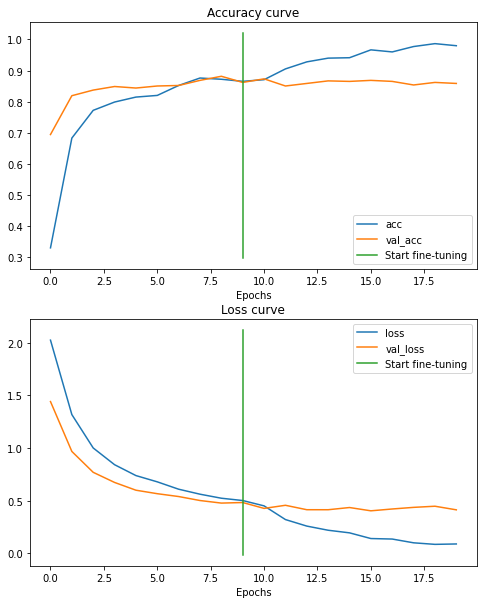

In [ ]:
from useful_functions_eval import compare_histories

compare_histories(history_1, history_2, initial_epochs)

### Model 3 - feature extraction, data aug and fine tuning (last 30 layers) for 10 more epochs

In [ ]:
# take weights of model 1 back to epoch=10
model_1.load_weights(checkpoint_path)

# set last 30 layers to trainable
model_1.trainable = True
for layer in model_1.layers[2].layers[:-30]:
  layer.trainable=False

for layer in model_1.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [ ]:
len(model_1.layers[2].trainable_variables)

28

In [ ]:
# compile model 1 to add changes
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

# fit -> fine-tune model 3 for additional 10 epochs
history_3 = model_1.fit(train_data, epochs=fine_tuning_epochs, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.25*len(test_data)), initial_epoch=initial_epochs, callbacks=[create_tensorboard_callback("experiments", "model_3_fine_tune_lasr_30")])

Saving TensorBoard log files to: experiments/model_3_fine_tune_lasr_30/Y0110-002242
Epoch 11/20
24/24 [==============================] - 16s 417ms/step - loss: 0.4412 - accuracy: 0.8800 - val_loss: 0.4113 - val_accuracy: 0.8635
Epoch 12/20
24/24 [==============================] - 8s 327ms/step - loss: 0.3278 - accuracy: 0.9000 - val_loss: 0.3959 - val_accuracy: 0.8668
Epoch 13/20
24/24 [==============================] - 9s 354ms/step - loss: 0.2573 - accuracy: 0.9213 - val_loss: 0.3835 - val_accuracy: 0.8750
Epoch 14/20
24/24 [==============================] - 8s 324ms/step - loss: 0.2544 - accuracy: 0.9400 - val_loss: 0.4028 - val_accuracy: 0.8553
Epoch 15/20
24/24 [==============================] - 8s 297ms/step - loss: 0.1763 - accuracy: 0.9493 - val_loss: 0.4031 - val_accuracy: 0.8586
Epoch 16/20
24/24 [==============================] - 9s 350ms/step - loss: 0.1567 - accuracy: 0.9613 - val_loss: 0.4558 - val_accuracy: 0.8536
Epoch 17/20
24/24 [==============================] - 9s 3

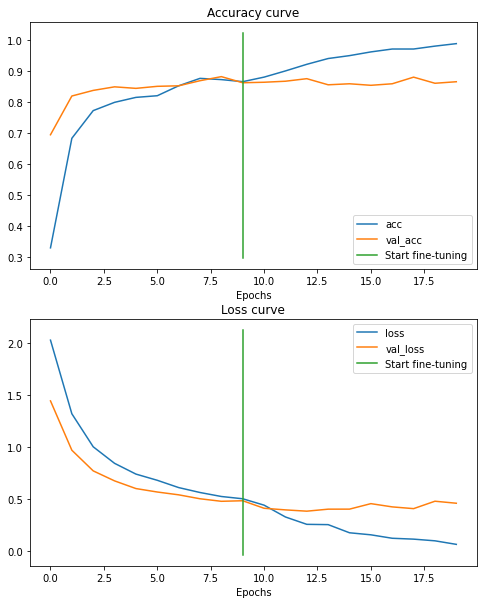

In [ ]:
compare_histories(history_1, history_3, initial_epochs)

# Visualization function for making predictions


In [ ]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_pred(model, test_data, class_names):
  """
    data --> `tf.data.Dataset` object with (image , label) tuples
  """
  image_batch , label_batch = test_data.as_numpy_iterator().next()
  batch_prob = [model.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2 , 2 , i + 1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"""Original label: {class_names[np.argmax(label_batch[i])]},
     predicted label: {batch_preds[i]},
     probability: {batch_prob[i].max():.2f}""" , c = title_color)
    plt.axis('off')



1/1 [==============================] - 0s 22ms/step


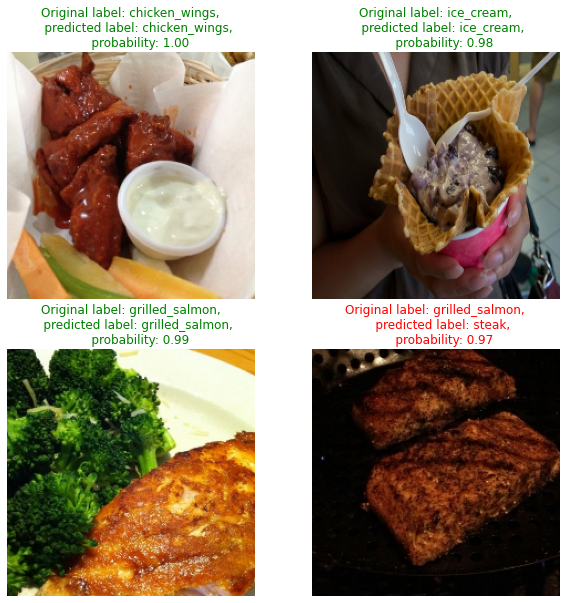

In [ ]:
plot_pred(model_1, test_data, test_data.class_names)